# Day2宿題
### 誤差検証手法の実践

* DAY1で作成したアルゴリズムに対して、
  * ホールドアウト法で汎化誤差を検証する
  * 交差検証（クロスバリデーション）法で汎化誤差を検証する
  * DAY1の予測精度からどう変化したかを検証する

### オーバーフィッティング対処方法の実践

* DAY1で作成したアルゴリズムに
  * 標準化手法を適用する
  * L1正則化手法を適用する（Lasso）…できてない
  * L2正則化手法を適用する（Ridge）…できてない

### モデルの精度を向上させるために切り口を変えた説明変数を検討

## ホールドアウト法と交差検証法をためしてみる

In [53]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.metrics import mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [54]:
#データの読み込み
df_fuel = pd.read_excel("./car-consume/measurements2.xlsx")

# データを確認
display(df_fuel.head())
df_fuel.describe()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN


,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters
count,388.000000,388.000000,388.000000,376.000000,388.000000,388.000000,388.000000,388.000000,13.000000
mean,19.652835,4.912371,41.927835,21.929521,11.358247,0.077320,0.123711,0.082474,37.115385
std,22.667837,1.033172,13.598524,1.010455,6.991542,0.267443,0.329677,0.275441,8.587282
min,1.300000,3.300000,14.000000,19.000000,-5.000000,0.000000,0.000000,0.000000,10.000000
25%,11.800000,4.300000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000,37.600000
50%,14.600000,4.700000,40.500000,22.000000,10.000000,0.000000,0.000000,0.000000,38.000000
75%,19.000000,5.300000,50.000000,22.500000,16.000000,0.000000,0.000000,0.000000,39.000000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000,45.000000


In [55]:
print('欠損値の数を確認==>\n', df_fuel.isnull().sum())

#欠損値０埋め
#ValueError: Input contains NaN, infinity or a value too large for dtype('float64').でないように
df_fuel = df_fuel.fillna(0)

欠損値の数を確認==>
 distance           0
consume            0
speed              0
temp_inside       12
temp_outside       0
specials         295
gas_type           0
AC                 0
rain               0
sun                0
refill liters    375
refill gas       375
dtype: int64


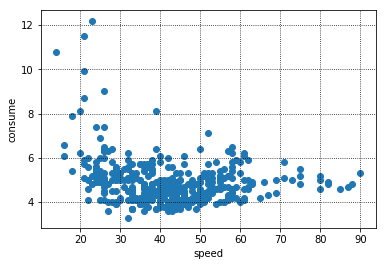

In [56]:
x = df_fuel["speed"].values
y = df_fuel["consume"].values

plt.scatter(x, y, marker='o')
plt.grid(which='major',color='black',linestyle=':')
plt.grid(which='minor',color='black',linestyle=':')
plt.ylabel('consume')
plt.xlabel('speed')
plt.show()

## ホールドアウト法

In [57]:
X = x.reshape(-1,1) # scikit-learnに入力するために整形
test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）

In [58]:
# 学習用データを使って線形回帰モデルを学習
regr = LinearRegression(fit_intercept=True)
regr.fit(X_train, y_train)

# 学習用データに対する予測を実行
y_pred_train = regr.predict(X_train)

# 学習データに対するMAEを計算（訓練誤差の評価）
mae = mean_absolute_error(y_train, y_pred_train)
print("訓練誤差MAE = %s"%round(mae,3) )

訓練誤差MAE = 0.684


In [59]:
# テストデータに対する予測を実行
y_pred_test = regr.predict(X_test)

# テストデータに対するMAEを計算（汎化誤差の評価）
mae = mean_absolute_error(y_test, y_pred_test)
print("汎化誤差MAE = %s"%round(mae,3) )

汎化誤差MAE = 0.704


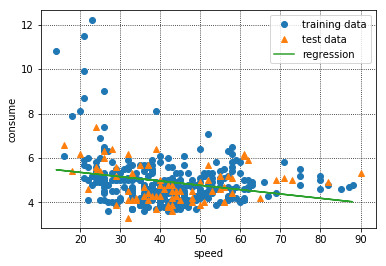

In [60]:
# グラフに重ねて表示する
plt.plot(X_train, y_train, 'o', label='training data')
plt.plot(X_test, y_test, '^', label='test data')
plt.ylabel("consume")
plt.xlabel("speed")
plt.grid(which='major',color='black',linestyle=':')
plt.grid(which='minor',color='black',linestyle=':')
plt.plot(X_train, y_pred_train, label='regression')
plt.legend(loc='best')
plt.show()

## 交差検証（クロスバリデーション）法

In [61]:
X = x.reshape(-1,1) # scikit-learnに入力するために整形
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_mae = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使って線形回帰モデルを学習
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = regr.predict(X_test)
    
    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_test, y_pred_test)
    print("Fold %s"%split_num)
    print("MAE = %s"%round(mae, 3))
    print()
    
    cross_valid_mae += mae #後で平均を取るためにMAEを加算
    split_num += 1

# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(final_mae, 3))

Fold 1
MAE = 0.704

Fold 2
MAE = 0.688

Fold 3
MAE = 0.797

Fold 4
MAE = 0.664

Fold 5
MAE = 0.587

Cross Validation MAE = 0.688


## 標準化

C:\Users\SST777087\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\SST777087\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([11., 47., 55., 85., 36., 45., 15.,  5.,  8.,  4.]),
 array([-2.01535767, -1.47662216, -0.93788665, -0.39915114,  0.13958437,
         0.67831989,  1.2170554 ,  1.75579091,  2.29452642,  2.83326193,
         3.37199744]),
 <a list of 10 Patch objects>)

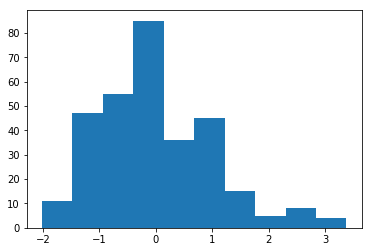

In [62]:
#データの標準化
stdsc = StandardScaler()
X_train_stand = stdsc.fit_transform(X_train)
plt.hist(X_train_stand[:, 0]) #標準化後の1つ目の特徴に関するヒストグラム（学習用データ）

C:\Users\SST777087\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([11.,  8.,  4., 12., 13., 11.,  7.,  5.,  5.,  1.]),
 array([-1.51915391, -1.20016578, -0.88117765, -0.56218952, -0.24320138,
         0.07578675,  0.39477488,  0.71376301,  1.03275114,  1.35173927,
         1.67072741]),
 <a list of 10 Patch objects>)

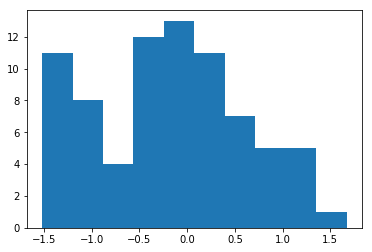

In [63]:
X_test_stand = stdsc.transform(X_test)
plt.hist(X_test_stand[:, 0]) #標準化後の1つ目の特徴に関するヒストグラム（テストデータ）

## 標準化後のホールドアウト法

In [64]:
# 学習用データを使って線形回帰モデルを学習
regr = LinearRegression(fit_intercept=True)
regr.fit(X_train, y_train)

# 学習用データに対する予測を実行
y_pred_train = regr.predict(X_train)

# 学習データに対するMAEを計算（訓練誤差の評価）
mae = mean_absolute_error(y_train, y_pred_train)
print("訓練誤差MAE = %s"%round(mae,3) )

訓練誤差MAE = 0.71


In [65]:
# テストデータに対する予測を実行
y_pred_test = regr.predict(X_test)

# テストデータに対するMAEを計算（汎化誤差の評価）
mae = mean_absolute_error(y_test, y_pred_test)
print("汎化誤差MAE = %s"%round(mae,3) )

汎化誤差MAE = 0.587


## 標準化後の交差検証法

In [66]:
X = x.reshape(-1,1) # scikit-learnに入力するために整形
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_mae = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使って線形回帰モデルを学習
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = regr.predict(X_test)
    
    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_test, y_pred_test)
    print("Fold %s"%split_num)
    print("MAE = %s"%round(mae, 3))
    print()
    
    cross_valid_mae += mae #後で平均を取るためにMAEを加算
    split_num += 1

# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(final_mae, 3))

Fold 1
MAE = 0.704

Fold 2
MAE = 0.688

Fold 3
MAE = 0.797

Fold 4
MAE = 0.664

Fold 5
MAE = 0.587

Cross Validation MAE = 0.688


## 異常値をなくしてみる

In [67]:
# 図を見た限りで、consume=7,11の2点が異常値としちゃう
conclusion =[]

# 異常値がないデータを作成する
fuel_test = df_fuel.copy()
fuel_final =  df_fuel.copy()
fuel_limit = fuel_test[((fuel_test.sun==0)&(fuel_test.consume<7))|(fuel_test.sun==1)].copy()

# 交差バリエーションを用いる
var_graph = []
var_data = fuel_limit.copy()
var_dataX = var_data[["distance","speed","temp_inside","temp_outside","sun","rain","AC"]]
var_datay = var_data[["consume"]]
x = var_dataX.values
y = var_datay.values
X = x.reshape(-1,7)
n_split =10
cross_valid_mae = 0
cross_valid_mae_train = 0
split_num = 1
split_num_train = 1

# 交差バリエーションを用いる
for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
   #学習用データ,テスト用データ
    X_train, y_train = X[train_idx], y[train_idx] 
    X_test, y_test = X[test_idx], y[test_idx]
    # 学習用データを使って線形回帰モデルを学習
    regr = LinearRegression(fit_intercept=False)
    regr.fit(X_train, y_train)

    # 訓練誤差を計算する
    y_pred_train = regr.predict(X_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    cross_valid_mae_train += mae_train 
    split_num_train += 1
   
    # 汎化誤差を計算する
    y_pred_test = regr.predict(X_test)    
    mae = mean_absolute_error(y_test, y_pred_test)
    cross_valid_mae += mae 
    split_num += 1

# MAEの平均値を最終的な汎訓練誤差値とする
final_mae_train = cross_valid_mae_train / n_split
var_graph.append(final_mae_train)
# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
var_graph.append(final_mae)
# lastデータの下準備
fuel_finalX = fuel_final[["distance","speed","temp_inside","temp_outside","sun","rain","AC"]].copy()
fuel_finaly = fuel_final[["consume"]].copy()
x_last = fuel_finalX.values
y_last = fuel_finaly.values
X_last = x_last.reshape(-1,7)
y_pred_last = regr.predict(X_last)
mae_final = mean_absolute_error(y_last, y_pred_last)
var_graph.append(mae_final)

# 1*3行列に変換
var_graph = np.reshape(var_graph,(1,3)) 
conclusion.append(var_graph)
var_graph = pd.DataFrame(var_graph ,index=["MAE"] ,columns = ["(var)訓練誤差","(var)汎化誤差","(var)最終的な誤差"])
display(var_graph) 

,(var)訓練誤差,(var)汎化誤差,(var)最終的な誤差
MAE,0.706823,0.776868,0.852321
